# <center>**Variance and SNR**<center>

**Libraries**

In [1]:
import numpy as np
from scipy.signal import correlate

import maskpattern as mp
import plot_module as plot
import balancing as bal
import stats

np.set_printoptions(precision=2, suppress=False)

In [ ]:
import importlib
importlib.reload(stats)

## **2D URA/MURA Masks with PCFOV**

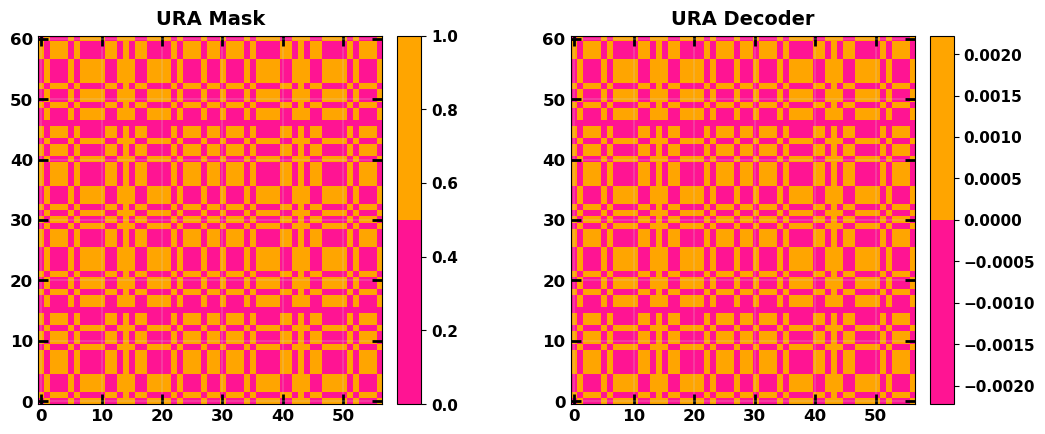

In [2]:
ura = mp.URAMaskPattern(4)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["URA Mask", "URA Decoder"])

- Let's first simulate a sky image and then perform the cross-correlation to obtain the sky reconstruction

- Here I will consider also the PCFOV and the reconstruction Balancing (see `pcfov_analysis.ipynb`)

In [3]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    sky_image = np.zeros(sky_image_shape)

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]

    # add sky background
    if sky_background_rate is not None:
        sky_background = np.random.poisson(sky_background_rate, sky_image_shape)
        sky_image += sky_background
    else:
        sky_background = None
    
    return sky_image, sky_background, sources_pos

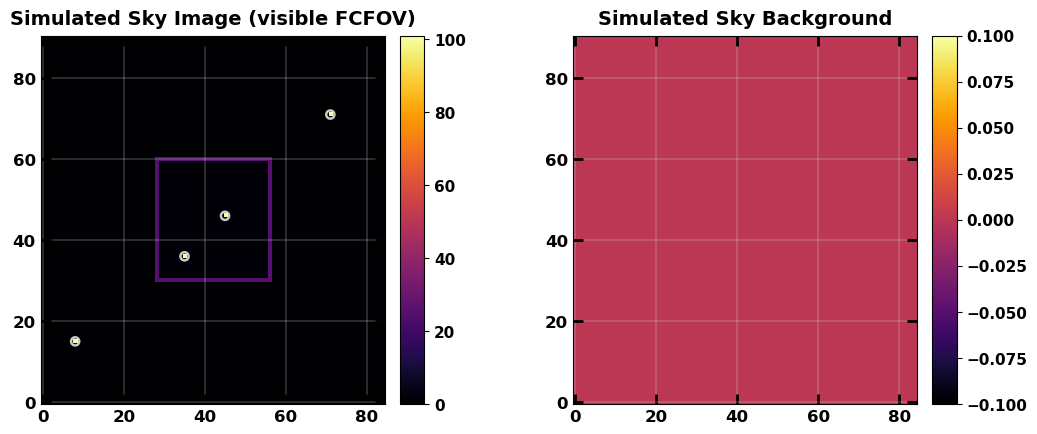

In [4]:
h, v = n - 1, m - 1
sky_shape = (n + 2*h, m + 2*v)

sources_flux = np.array([100, 100, 100, 100])
sources_pos = [(h - 15, v - 20), (n + 5, m + 6), (n + 15, m + 16), (h + n + 10, v + m + 14)]
sky_background_rate = 0

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

highlight_fcfov = True
if highlight_fcfov:
    base = np.ones((n - 2, m - 2))
    c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

else:
    plot.image_plot([sky_image, sky_background],
                    ["Simulated Sky Image", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

cc_detector_image = sky image shape: True
pcfov_sky_reconstruction = sky image shape: True
balanced_sky_reconstruction = sky image shape: True
pcfov_sky_reconstruction = bal_sky_reconstruction shape: True
fcfov_sky_reconstruction = basic pattern shape: True

S_hat[0] - S[0]: -81.77777777777779
Bal_S_hat[0] - S[0]: 26.260869565217277

S_hat[1] - S[1]: 0.44444444444441444
Bal_S_hat[1] - S[1]: 0.2811185350160912

S_hat[2] - S[2]: 3.5555555555555003
Bal_S_hat[2] - S[2]: 3.3956941351150505

S_hat[3] - S[3]: -67.55555555555557
Bal_S_hat[3] - S[3]: -2.220407329896446



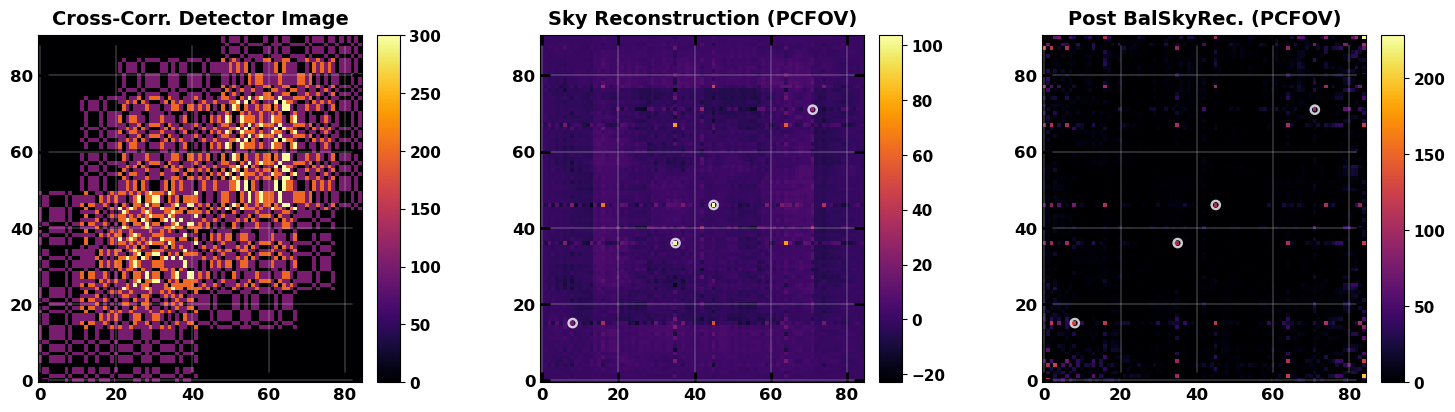

In [36]:
cc_detector_image = correlate(mask, sky_image, mode='full')[h : -h, v : -v]
fcfov_detector_image = cc_detector_image[h : -h, v : -v]                            ### detector area corresponding to FCFOV

pcfov_sky_reconstruction = correlate(decoder, fcfov_detector_image, mode='full')    ### here the FCFOV portion of the central detector image
fcfov_sky_reconstruction = pcfov_sky_reconstruction[h : -h, v : -v]

bulk_array = np.ones(fcfov_detector_image.shape)
balancing = bal.BalancedSkyReconstruction_Goldwurm(mask, decoder, bulk_array)
bal_sky_reconstruction, balskyrec_var = balancing.balanced_sky_reconstruction(fcfov_detector_image)

print(f"cc_detector_image = sky image shape: {np.all(cc_detector_image.shape == sky_shape)}\n"
      f"pcfov_sky_reconstruction = sky image shape: {np.all(pcfov_sky_reconstruction.shape == sky_shape)}\n"
      f"balanced_sky_reconstruction = sky image shape: {np.all(bal_sky_reconstruction.shape == sky_shape)}\n"
      f"pcfov_sky_reconstruction = bal_sky_reconstruction shape: {np.all(pcfov_sky_reconstruction.shape == bal_sky_reconstruction.shape)}\n"
      f"fcfov_sky_reconstruction = basic pattern shape: {np.all(fcfov_sky_reconstruction.shape == (n, m))}\n")

for idx, pos in enumerate(sources_pos):
    print(f"S_hat[{idx}] - S[{idx}]: {pcfov_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"Bal_S_hat[{idx}] - S[{idx}]: {bal_sky_reconstruction[*pos] - sky_image[*pos]}\n")

threshold = 300
post_bal_sky_reconstruction = bal_sky_reconstruction.copy()
post_bal_sky_reconstruction[bal_sky_reconstruction > threshold] = 0     # remove artifacts
post_bal_sky_reconstruction[bal_sky_reconstruction < 0] = 0       # remove negative counts

plot.image_plot([cc_detector_image, pcfov_sky_reconstruction, post_bal_sky_reconstruction],
                ["Cross-Corr. Detector Image", "Sky Reconstruction (PCFOV)", "Post BalSkyRec. (PCFOV)"],
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, sources_pos])

- Let's see how the variance of the reconstructed sky behaves (balanced sky reconstruction variance in Goldwurm)

S_hat[0] - S[0]: -81.77777777777779
Bal_S_hat[0] - S[0]: 26.260869565217277
Bal_Var_S_hat[0]: 4.204360428481415

S_hat[1] - S[1]: 0.44444444444441444
Bal_S_hat[1] - S[1]: 0.2811185350160912
Bal_Var_S_hat[1]: 0.5498625037439496

S_hat[2] - S[2]: 3.5555555555555003
Bal_S_hat[2] - S[2]: 3.3956941351150505
Bal_Var_S_hat[2]: 0.549847088868423

S_hat[3] - S[3]: -67.55555555555557
Bal_S_hat[3] - S[3]: -2.220407329896446
Bal_Var_S_hat[3]: 2.1547303580204877



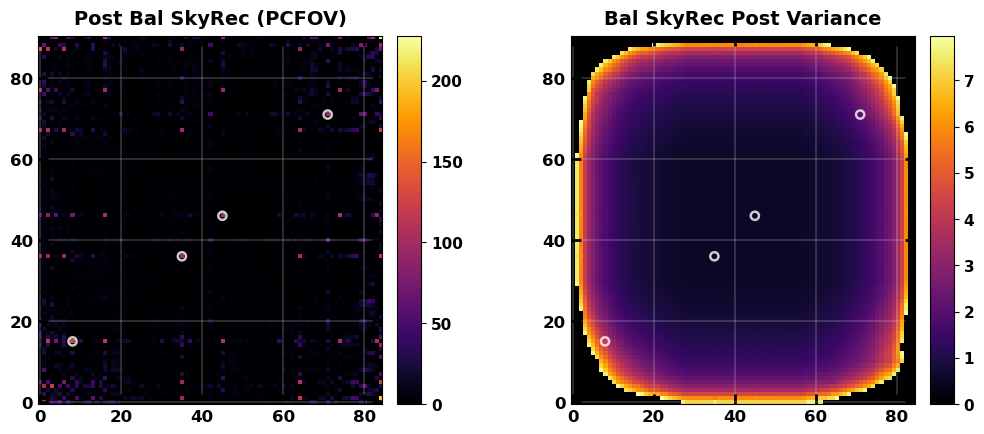

In [59]:
for idx, pos in enumerate(sources_pos):
    print(f"S_hat[{idx}] - S[{idx}]: {pcfov_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"Bal_S_hat[{idx}] - S[{idx}]: {bal_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"Bal_Var_S_hat[{idx}]: {balskyrec_var[*pos]}\n")


var_threshold = 8
post_balskyrec_var = balskyrec_var.copy()
post_balskyrec_var[post_balskyrec_var > var_threshold] = 0     # remove artifacts due to negative counts in sky_reconstruction

plot.image_plot([post_bal_sky_reconstruction, post_balskyrec_var],
                ["Post Bal SkyRec (PCFOV)", "Bal SkyRec Post Variance"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

- The variance, as expected, grows towards the edges (i.e. towards the PCFOV), while being about constant in the FCFOV

- If the non-balanced variance is used ($Var(\hat{S}) = G^{2} \star D$, where Var(D) = D since Poisson counts are assumed):

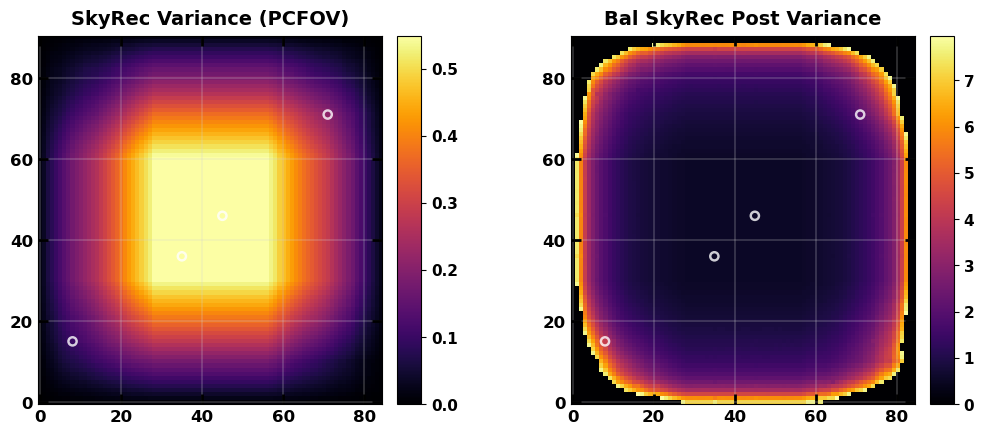

In [61]:
var = stats.variance(decoder, fcfov_detector_image)

plot.image_plot([var, post_balskyrec_var],
                ["SkyRec Variance (PCFOV)", "Bal SkyRec Post Variance"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[sources_pos, sources_pos])

- If we compute the SNR:
$$SNR = {\hat{S} \over \sqrt{Var(\hat{S})}}$$

SNR[0] (basic): 56.585375866073015
SNR[0] (hybrid): 392.0772491080815
SNR[0] (bal): 61.57703964485385

SNR[1] (basic): 135.54579252231915
SNR[1] (hybrid): 135.32539068769967
SNR[1] (bal): 135.23593773647045

SNR[2] (basic): 139.7441135296476
SNR[2] (hybrid): 139.5283868854594
SNR[2] (bal): 139.43811018617328

SNR[3] (basic): 70.57176370033342
SNR[3] (hybrid): 212.68597526597478
SNR[3] (bal): 66.61189035322141



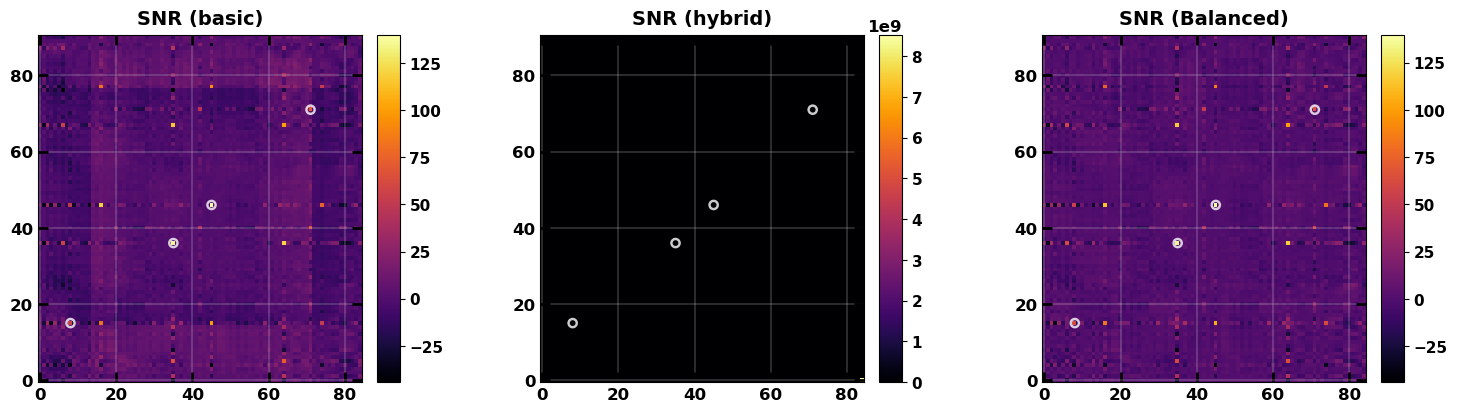

In [65]:
basic_snr = stats.snr(decoder, fcfov_detector_image, pcfov_sky_reconstruction)
hybrid_snr = stats.snr(decoder, fcfov_detector_image, bal_sky_reconstruction)
bal_snr = bal_sky_reconstruction/np.sqrt(balskyrec_var)

for idx, pos in enumerate(sources_pos):
    print(f"SNR[{idx}] (basic): {basic_snr[*pos]}\n"
          f"SNR[{idx}] (hybrid): {hybrid_snr[*pos]}\n"
          f"SNR[{idx}] (bal): {bal_snr[*pos]}\n")

plot.image_plot([basic_snr, hybrid_snr, bal_snr],
                ["SNR (basic)", "SNR (hybrid)", "SNR (Balanced)"],
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, sources_pos, sources_pos])